In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

def display_imgs(imgs, rows, cols, figsize=(20, 10), cmap='gray'):
    plt.figure(figsize=figsize)
    idx = 1
    for img in imgs:
        plt.subplot(rows, cols, idx)
        plt.imshow(img, cmap=cmap)
        idx += 1

In [2]:
from constants.constants import CHESSBOARD_CORNERS
from filters.blur_filter import BlurFilter
from filters.clahe_filter import CLAHEFilter
from filters.grayscale_filter import GrayscaleFilter
from filters.gradient_direction_threshold_filter import GradientDirectionThresholdFilter
from filters.gradient_magnitude_threshold_filter import GradientMagnitudeThresholdFilter
from filters.gradient_threshold_filter import GradientThresholdFilter
from filters.hls_threshold_filter import HLSThresholdFilter
from filters.hsv_threshold_filter import HSVThresholdFilter
from filters.s_channel_filter import SaturationChannelFilter
from filters.lane_region_mask_filter import LaneRegionMaskFilter
from filters.lane_perspective_transform_filter import LanePerspectiveTransformFilter
from filters.undistort_filter import UndistortFilter
from filters.filter_ops import and_filters, or_filters, weighted_and_filters
from filters.lane_line_detector import LaneLineDetector
from filters.curvature_details_filter import CurvatureDetailsFilter
import numpy as np

# Undistort filter
chessboard_imgs = [cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) for image_path in glob.glob('camera_cal/*.jpg')]
undistort_filter = UndistortFilter(chessboard_imgs, CHESSBOARD_CORNERS[0], CHESSBOARD_CORNERS[1])
# Blur filter
blur_filter = BlurFilter()
# Grayscale filter
grayscale_filter = GrayscaleFilter(low_threshold=150, high_threshold=255)
# SaturationChannelFilter
s_channel_filter = SaturationChannelFilter()
# CLAHE filter
clahe_filter = CLAHEFilter()
# HSL filter
s_threshold_filter = HLSThresholdFilter(h_thresholds=(0, 255), l_thresholds=(0, 255), s_thresholds=(70, 255))
# Gradient threshold filter
gradx_threshold_filter = GradientThresholdFilter(low_threshold=5, high_threshold=255, orientation='x')
grady_threshold_filter = GradientThresholdFilter(low_threshold=5, high_threshold=255, orientation='y')
# Gradient magnitude filter
grad_mag_threshold_filter = GradientMagnitudeThresholdFilter(low_threshold=5, high_threshold=255)
# Gradient direction filter
grad_dir_threshold_filter = GradientDirectionThresholdFilter(low_threshold=0.7, high_threshold=1.2)
# Lane Region mask filter
lane_region_mask_filter = LaneRegionMaskFilter()
lane_perpective_transform_filter = LanePerspectiveTransformFilter((720, 1280))
inverse_lane_perpective_transform_filter = LanePerspectiveTransformFilter((720, 1280), inverse=True)
lane_line_detector = LaneLineDetector()
curvature_details_filter = CurvatureDetailsFilter()


In [3]:
# Pipeline for lane detection
from filters.filter_chain import FilterChain

composite_gradient_filter = and_filters([
    gradx_threshold_filter,
    grad_mag_threshold_filter,
    grad_dir_threshold_filter
])

chain = FilterChain([
    undistort_filter,
    blur_filter,
    weighted_and_filters([
        s_threshold_filter,
        FilterChain([
            grayscale_filter, 
            composite_gradient_filter
        ]),
        FilterChain([
            s_threshold_filter, 
            composite_gradient_filter
        ]),
        FilterChain([
            s_channel_filter, 
            composite_gradient_filter
        ])
    ], 0.25),
    lane_region_mask_filter,
    lane_perpective_transform_filter,
    blur_filter,
    lane_line_detector,
    inverse_lane_perpective_transform_filter,
    curvature_details_filter
])

# Function that detects and superimposes lanes on images.
def detect_lanes(img, context=None):
    return cv2.addWeighted(img, 1.0, chain.apply(img, context), 0.2, 0.0)
    

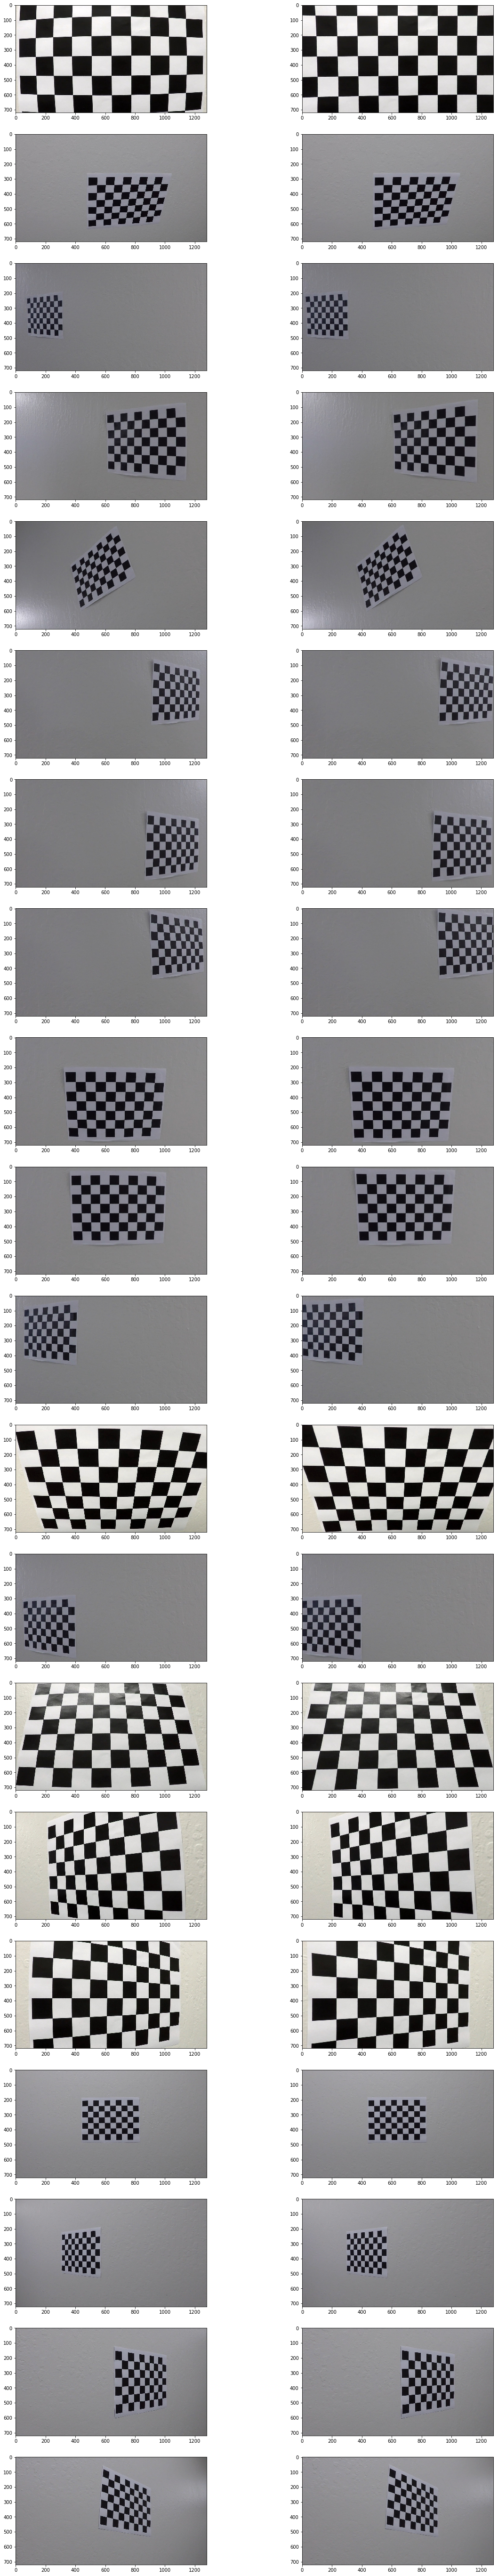

In [4]:
# Undistortion for chessboard images
imgs = []
for original in chessboard_imgs:
    imgs.extend([original, undistort_filter.apply(original, None)])

display_imgs(imgs, 20, 2, figsize=(20, 100))

In [5]:
# Undistortion for chessboard images
imgs = []
for original in chessboard_imgs:
    imgs.extend([original, undistort_filter.apply(original, None)])

display_imgs(imgs, 20, 2, figsize=(20, 100))

NameError: name 'original_imgs' is not defined

In [ ]:
# Undistortion for test images
original_imgs = [cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) for image_path in glob.glob('test_images/*.jpg')]
imgs = []
for original in original_imgs:
    imgs.extend([original, detect_lanes(original)])

display_imgs(imgs, 20, 2, figsize=(20, 100))


In [ ]:
from filters.filter_context import FilterContext

print("Lane detection pipeline:")
print("========================")
processed = []

class DebugVisitor:
    def __init__(self):
        self.depth = 0
        
    def start_chain(self):
        self.depth += 1
        
    def end_chain(self):
        self.depth -= 1
        
    def processed(self, img, image_filter):
        print('{}Depth={}/{}'.format(' ' * self.depth * 4, self.depth, image_filter.__class__.__name__))
        copy = np.copy(img)
        if np.max(copy) <= 1.0:
            copy = copy * 255
        cv2.putText(
            copy, 
            'Depth={}/{}'.format(self.depth, image_filter.__class__.__name__), 
            (100, 100), 
            cv2.FONT_HERSHEY_COMPLEX_SMALL, 
            2, 
            (230, 230 , 230),
            thickness=5)
        processed.append(copy)

context_with_debug_fn = FilterContext(DebugVisitor())
lane_detected = detect_lanes(original_imgs[0], context_with_debug_fn)
all_imgs = []
all_imgs.append(original_imgs[0])
all_imgs.extend(processed)
all_imgs.append(lane_detected)

display_imgs(all_imgs, 20, 2, figsize=(20, 100))

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

project_video_output = 'output/project_video.mp4'
project_video_clip = VideoFileClip("./project_video.mp4")
context = FilterContext()
video_imgs = []
def add_imgs(img):
    video_imgs.append(img)
    return img
project_video_clip = project_video_clip.fl_image(lambda img : detect_lanes(img, context))
project_video_clip = project_video_clip.fl_image(lambda img : add_imgs(img))
%time project_video_clip.write_videofile(project_video_output, audio=False)


HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))